# Machine learning final project
- Authors: 
    - Gabriel Kiprono 
    - William Lewis
- Your job is to develop tools to analyze tweets about airlines.
Download the following dataset: https://www.kaggle.com/crowdflower/twitter-airline-sentiment
- You must develop at least two tools.
-a sentiment analysis tool to classify tweets as positive, negative, or neutral
a tool that clusters similar tweets for a particular airline together and selects a representative tweet from each cluster characterizing the cluster
Deliverables
- You will turn in a Jupyter notebook for each tool that demonstrates your work.
- Also, for each tool, you will turn in a report documenting the process you followed to make your choices about how to preprocess your data and how to build, tune, and test your tools as well as why you think those were reasonable choices to make
- The report must include an appropriate estimate of your sentiment classifier’s accuracy.
You are free to use resources you find online, just cite them AND explain what you learned from those resources.
You must convince me that you really understand what you did and why you did it.
- Don’t use it if you can’t explain it.
- For students in CSC 5220, you will also (individually) build a tool that identifies the 5 most frequent words (not counting stopwords) in positive tweets, negative tweets, and in each cluster you identify.

## Step 1: Read the data

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
import string

- Read the data

In [2]:
tweets = pd.read_csv("Tweets.csv")
tweets.columns
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


- Data visualization

In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from termcolor import cprint
import seaborn as sns
import warnings   


warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
tweets = tweets[tweets['airline'] == 'Delta']

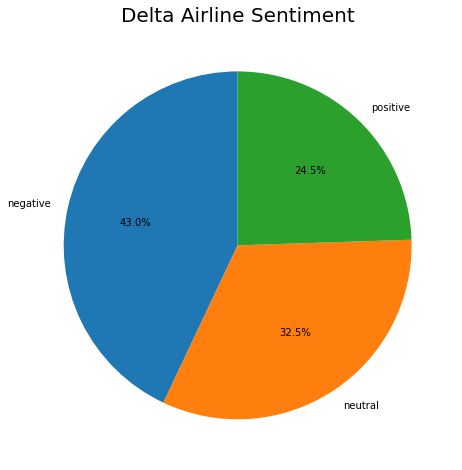

In [5]:
# plot a pie chart for airline_sentiment
fig = plt.figure(figsize = (10, 8))
labels = 'negative', 'neutral', 'positive'
plt.pie(tweets.airline_sentiment.value_counts(), labels = labels, autopct = '%1.1f%%', startangle = 90)
plt.title('Delta Airline Sentiment', fontsize = 20)
plt.show()

In [6]:
cprint("Sentiments tweets for Delta airline: ", 'white')
airlines= ['Delta']

for airline in airlines:
  print('{} : \n' .format(airline), tweets.loc[tweets.airline == airline].airline_sentiment.value_counts())


Sentiments tweets for Delta airline: 
Delta : 
 negative    955
neutral     723
positive    544
Name: airline_sentiment, dtype: int64


Reasons for -ve tweets

Reasons Of Negative Tweets :
Late Flight                    269
Customer Service Issue         199
Can't Tell                     186
Bad Flight                      64
Flight Attendant Complaints     60
Lost Luggage                    57
Cancelled Flight                51
Flight Booking Problems         44
longlines                       14
Damaged Luggage                 11
Name: negativereason, dtype: int64


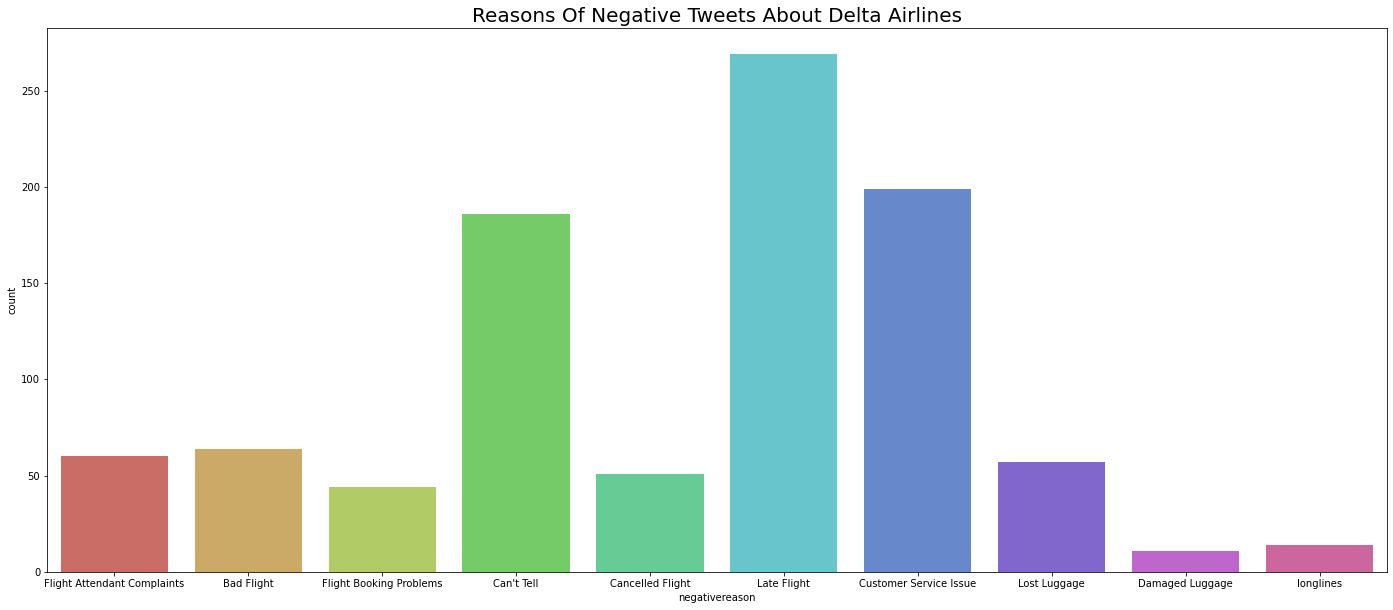

In [7]:
cprint('Reasons Of Negative Tweets :','green')
print(tweets.negativereason.value_counts())

plt.figure(figsize = (24, 10))
sns.countplot(x = 'negativereason', data = tweets, palette = 'hls')
plt.title('Reasons Of Negative Tweets About Delta Airlines', fontsize = 20)
plt.show()

Splitting the sentiments


In [8]:
positive = tweets[tweets['airline_sentiment'] == 'positive'].text
neutral  = tweets[tweets['airline_sentiment'] == 'neutral'].text
negative  = tweets[tweets['airline_sentiment'] == 'negative'].text

Positive sentimets

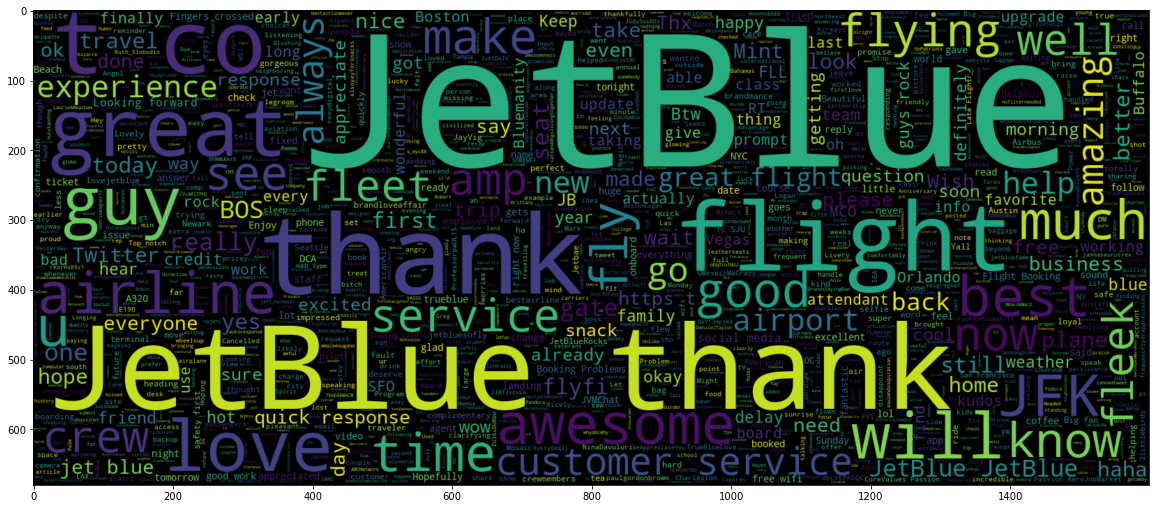

In [9]:
plt.figure(figsize = (20,20)) 
worldcould_pos = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(positive))
plt.imshow(worldcould_pos,interpolation = 'bilinear')

Negative sentiments

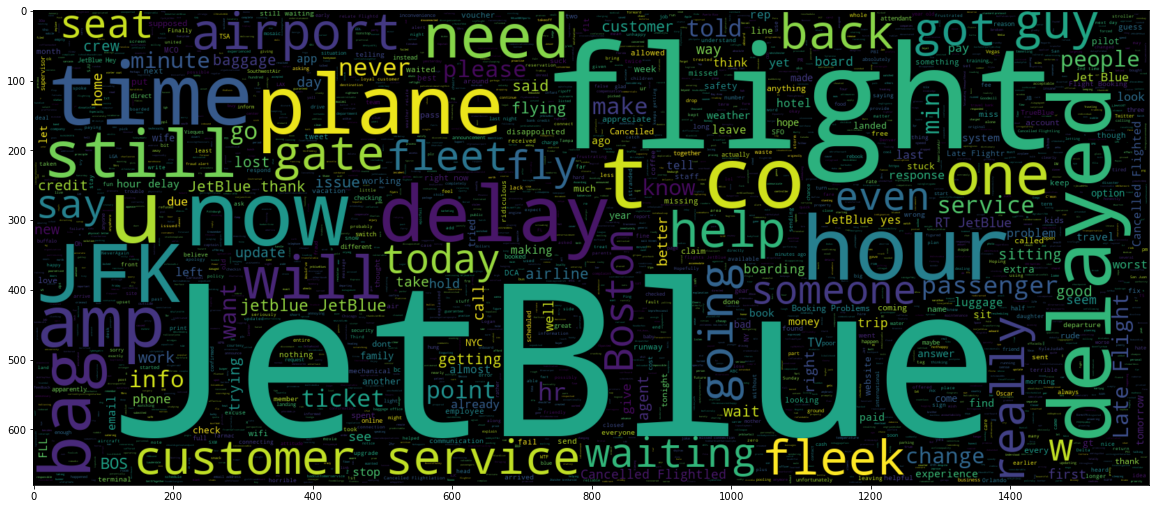

In [10]:
plt.figure(figsize = (20,20)) 
worldcould_pos = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(negative))
plt.imshow(worldcould_pos,interpolation = 'bilinear')
# ax.grid(False)

Neutral sentiments

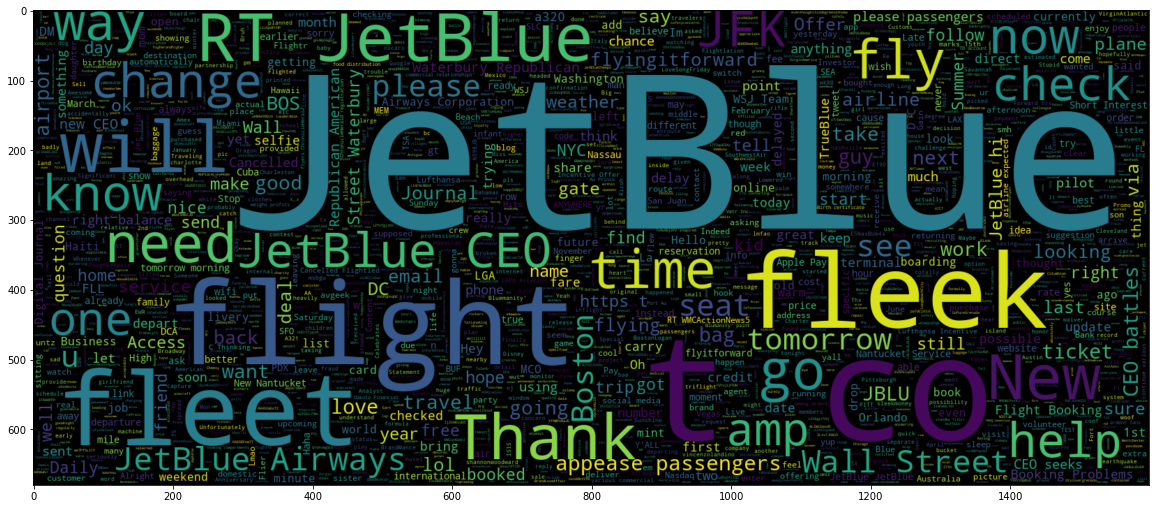

In [11]:
plt.figure(figsize = (20,20)) 
worldcould_pos = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(neutral))
plt.imshow(worldcould_pos,interpolation = 'bilinear')
# ax.grid(False)

# Feature processing

In [12]:
#encode sentiments
def encode_sentiment(sentiment):
  if sentiment == "positive":
    return 2
  elif sentiment == "neutral":
    return 1
  elif sentiment == "negative":
    return 0


tweets.airline_sentiment = tweets.airline_sentiment.apply(lambda x : encode_sentiment(x))

# Data cleaning by: <a href = "https://www.kaggle.com/meisamraz/sentiment-analysis-96-acc-eda-text-preprocessing">Meisam Raz</a>

In [13]:
# Remove stop words
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    return text

# Remove url  
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Remove punct
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove html 
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove @username
def remove_username(text):
    return re.sub('@[^\s]+','',text)

# Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Decontraction text
def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text  

# Seperate alphanumeric
def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute


In [14]:
tweets['final_text'] = tweets['negativereason'].fillna('') + ' ' + tweets['text'] 

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# clean utility
def clean_text(tweets):
    tweets['final_text'] = tweets['final_text'].apply(lambda x : remove_username(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : remove_url(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : remove_emoji(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : decontraction(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : seperate_alphanumeric(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : unique_char(cont_rep_char,x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : char(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : x.lower())
    tweets['final_text'] = tweets['final_text'].apply(lambda x : remove_stopwords(x))

    return tweets


# apply the functions
tweets = clean_text(tweets)


Cleaning input for the prediction

In [29]:
X = tweets['final_text']
y = tweets['airline_sentiment']

X.shape

(2222,)

## TFidVectorizer
- Convert a collection of raw documents to a matrix of TF-IDF features.
- Takes care of the frequent words

This is an important step to remove a lot of noise from the 
data including things like punctuation marks which are not believed to aid in the analysis.

In [30]:
# apply tfidf to the cleaned text
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(X)

# Smote
- SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem. 
- It is a technique that takes minority samples and creates synthetic samples from them.
- It is used to deal with the imbalanced data problem.
- it generates the virtual samples from the minority class by linear interpolation. for the minority class.

<a href = "https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/"> Link to the article </a>

In [32]:
#applying smote
from imblearn.over_sampling import SMOTE  # Handling Imbalanced
smote = SMOTE()
x_sm,y_sm = smote.fit_resample(X_tfidf,y)


# Clustering

In [22]:
from sklearn.cluster import KMeans

# Elbow Method

Here we attempted to implement the elbow method and found that 7 seemed to be the correct value for k. Using the data from the Elbow method, we decided k should have a value of 7 because the rate of decrease in distances seemed to drop significantly at that point.

In [62]:
true_k = 20

# A list holds the SSE values for each k
sse = []
for k in range(1, true_k):
  model = KMeans(n_clusters=k, init="k-means++", random_state=87)
  model.fit(x_sm)
  sse.append(model.inertia_)


## Plotting the Elbow

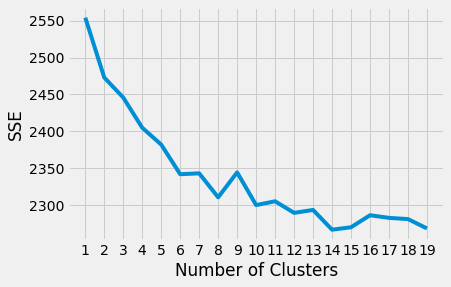

In [63]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, true_k), sse)
plt.xticks(range(1, true_k))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


## Most important Words in each cluster

In this section, we recreate the KMeans model using the perceived best number of clusters. 

Next, we sort the centroids in order of decreasing significance so that we can print the top 5 terms from each cluster by selecting the feature names from the TfidfVectorizer.

Cluster 3 appears to be populated by marketing as prominent words in Cluster 2 are things like "rt" (retweet), "fleek", "fleet". Closer inspection of tweets with "fleet" and "fleek" seemed to indicate that "fleet" and "fleek" were part of a phrase introduced by Delta for purposes of viral marketing.

Clusters 2, 6, and 5 all seemed to contain positive clusters based on the most important terms. Words in these clusters included "love", "great", "thanks", "thank", "awesome", "service". "Service" in addition to the positive words in the cluster leads one to assume that those tweets feel positively about the service they received.


In [66]:
true_k = 7

model = KMeans(n_clusters=true_k)
predicts = model.fit_predict(x_sm)
print("Top terms per cluster:")
centroids = model.cluster_centers_
order_centroids = centroids.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind]),
    print

print("\n")


Top terms per cluster:
Cluster 0:
 flight
 late
 delayed
 cancelled
 delay
Cluster 1:
 ca
 tell
 travel
 wait
 flight
Cluster 2:
 thank
 love
 thanks
 flight
 great
Cluster 3:
 fleek
 fleet
 rt
 stop
 tell
Cluster 4:
 ceo
 wall
 passengers
 street
 battles
Cluster 5:
 customer
 service
 issue
 flight
 time
Cluster 6:
 thanks
 awesome
 good
 help
 update




# Labels
In this section, we double check the labels to be certain of what they are.

In [68]:
u_labels = np.unique(predicts)
u_labels

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

# Print Cluster Representative Tweets

We decided to print the first tweet found from each predicted cluster label. We had some concern that the first tweets would not be good representatives but, these representative tweets seem to mirror our earlier analysis using the most important terms. Although, representative Tweet 5 might indicate that Cluster 5 is just populated by tweets that are either exhibit politeness or passive-aggression.

In [69]:
index_list = model.labels_.tolist()
for num in range(0, len(u_labels)):
  print("Representative %d:" % num, tweets['final_text'].iloc[index_list.index(num)])


Representative 0: flight savannah ga
Representative 1: ca tell aisles empty evermoreroom seats move bc pay nonsense waste jetblue jetbluebos cheap
Representative 2: yesterday way ewr fll take wheelsup jetbluesofly
Representative 3: enjoy fleet fleek
Representative 4: ceo challenge appease passengers wall street columbian
Representative 5: customer service issue spent three hours talking different people could help probably using jetblue
Representative 6: update flight would appreciated time thanks
